In [1]:
'''
Outline so far:
1. Read in the data, set new col names
2. Engineer features
    2a) From NHANES, get mean FVC and FEV1 by age
    2b) Get interactions as in that Xu paper. What is the intuition behind them?
3. Select numeric cols
4. Fix strings, change F/T to 0/1
5. Encoding: Performance and Tumor_size to ordinal, DGN with OneHot
6. Split train/test
    5a) Balancing? Maybe up-sample the positive (dies) class? - need to do this
        on training fold ONLY while doing K-folds
7. Fit scaler to train, transform train/test

Seems LIME requires categorical features to be ints, with a mapping
from int to string for the actual name. Create that map early
'''

'\nOutline so far:\n1. Read in the data, set new col names\n2. Engineer features\n    2a) From NHANES, get mean FVC and FEV1 by age\n    2b) Get interactions as in that Xu paper. What is the intuition behind them?\n3. Select numeric cols\n4. Fix strings, change F/T to 0/1\n5. Encoding: Performance and Tumor_size to ordinal, DGN with OneHot\n6. Split train/test\n    5a) Balancing? Maybe up-sample the positive (dies) class? - need to do this\n        on training fold ONLY while doing K-folds\n7. Fit scaler to train, transform train/test\n\nSeems LIME requires categorical features to be ints, with a mapping\nfrom int to string for the actual name. Create that map early\n'

In [2]:
import pandas as pd
import seaborn as sns

spirometry = pd.read_sas('SPX_G.XPT')
demographics = pd.read_sas('DEMO_G.XPT')
body = pd.read_sas('BMX_G.XPT')

# 1 is male, 2 is female for sex
subset = spirometry[['SPXNFVC', 'SPXNFEV1', 'SEQN']]
demo_sub = demographics[['RIDAGEYR', 'RIAGENDR', 'SEQN']]
body_sub = body[['BMXHT', 'BMXWT', 'SEQN']]
subset = pd.merge(subset, demo_sub, 'left', 'SEQN')
subset = pd.merge(subset, body_sub, 'left', 'SEQN')
subset.rename(columns = {'SPXNFVC': 'FVC', 'SPXNFEV1': 'FEV1',
                        'RIDAGEYR': 'Age', 'RIAGENDR': 'Sex', 
                        'BMXHT': 'Height', 'BMXWT': 'Weight'}, inplace=True)
subset = subset.dropna()
subset

,FVC,FEV1,SEQN,Age,Sex,Height,Weight
0,4536.0,4265.0,62161.0,22.0,1.0,172.3,69.2
1,3667.0,3563.0,62163.0,14.0,1.0,168.9,49.4
2,4566.0,3397.0,62164.0,44.0,2.0,170.1,67.2
3,2531.0,2207.0,62165.0,14.0,2.0,159.4,69.1
4,1822.0,1715.0,62166.0,9.0,1.0,133.4,28.8
...,...,...,...,...,...,...,...
7490,4204.0,3323.0,71912.0,40.0,1.0,177.3,87.8
7491,4167.0,3461.0,71913.0,18.0,2.0,161.6,56.5
7492,2172.0,1833.0,71914.0,10.0,2.0,148.1,32.3
7493,4585.0,3174.0,71915.0,60.0,1.0,168.8,78.4


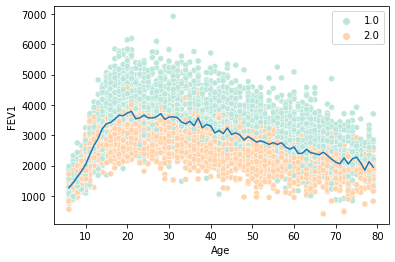

In [3]:
estimates = subset.groupby('Age')[['FVC', 'FEV1']].mean()
estimates.rename(columns={'FVC':'mean_FVC', 'FEV1':'mean_FEV1'}, inplace=True)

sns.scatterplot(x=subset['Age'], y=subset['FEV1'], hue=subset['Sex'], palette=sns.color_palette('icefire', as_cmap=True))
sns.lineplot(x=estimates.index.values, y=estimates['mean_FEV1'])

In [4]:
import pandas as pd

surgery = pd.read_csv('ThoracicSurgery.csv', index_col = 0)
surgery.rename(columns = {'DNG': 'Diagnosis', 'PRE4': 'FVC',
                            'PRE5': 'FEV1', 'PRE6': 'Performance',
                            'PRE7': 'Pain', 'PRE8': 'Haemoptysis',
                            'PRE9': 'Dyspnoea', 'PRE10': 'Cough',
                            'PRE11': 'Weakness', 'PRE14': 'Tumor_size',
                            'PRE17': 'Type2_diabetes', 'PRE19': 'MI_6months',
                            'PRE25': 'PAD', 'PRE30': 'Smkoing',
                            'PRE32': 'Asthma', 'AGE': 'Age'}, inplace=True)

In [5]:
# The CDC's NHANES data topcodes ages at 80, so we do the same for
# predicting FVC and FEV1 by age

for i in range(80,int(surgery.Age.max())+1):
    estimates = estimates.append(pd.Series(data=dict({'mean_FVC': estimates.loc[79.0,'mean_FVC'],
                                                      'mean_FEV1': estimates.loc[79.0,'mean_FEV1']}), 
                                           name=float(i)))

estimates

,mean_FVC,mean_FEV1
Age,,
6.0,1462.288557,1272.482587
7.0,1658.377660,1437.420213
8.0,1907.735294,1628.053922
9.0,2142.935000,1816.085000
10.0,2386.464088,2034.193370
...,...,...
83.0,2825.937500,1953.312500
84.0,2825.937500,1953.312500
85.0,2825.937500,1953.312500


In [6]:
surgery['FEV1/FVC'] = surgery['FEV1'] / surgery['FVC']
surgery['expected_FVC'] = estimates.loc[surgery.Age, 'mean_FVC'].values / 1000
surgery['expected_FEV1'] = estimates.loc[surgery.Age, 'mean_FEV1'].values / 1000
surgery['expected_FEV1/FVC'] = surgery['expected_FEV1'] / surgery['expected_FVC']
surgery['FVC_deficit'] = surgery['expected_FVC']-surgery['FVC']
surgery['FEV1_deficit'] = surgery['expected_FEV1']-surgery['FEV1']
surgery['FEV1/FVC_deficit'] = surgery['expected_FEV1/FVC']-surgery['FEV1/FVC']
surgery['FEV1^2'] = surgery['FEV1']**2
surgery['FVC^2'] = surgery['FVC']**2


surgery['Age*FVC'] = surgery['Age']*surgery['FVC']
surgery['Age*FEV1'] = surgery['Age']*surgery['FEV1']
surgery['FVC*FEV1'] = surgery['FVC']*surgery['FEV1']
surgery['FVC^2*FEV1'] = surgery['FEV1']*(surgery['FVC']**2)
surgery['FVC*FEV1^2'] = surgery['FVC']*(surgery['FEV1']**2)

surgery

,DGN,FVC,FEV1,Performance,Pain,Haemoptysis,Dyspnoea,Cough,Weakness,Tumor_size,...,FVC_deficit,FEV1_deficit,FEV1/FVC_deficit,FEV1^2,FVC^2,Age*FVC,Age*FEV1,FVC*FEV1,FVC^2*FEV1,FVC*FEV1^2
0,b'DGN2',2.88,2.16,b'PRZ1',b'F',b'F',b'F',b'T',b'T',b'OC14',...,0.596967,0.450341,0.000752,4.6656,8.2944,172.80,129.60,6.2208,17.915904,13.436928
1,b'DGN3',3.40,1.88,b'PRZ0',b'F',b'F',b'F',b'F',b'F',b'OC12',...,0.221250,0.893609,0.212985,3.5344,11.5600,173.40,95.88,6.3920,21.732800,12.016960
2,b'DGN3',2.76,2.08,b'PRZ1',b'F',b'F',b'F',b'T',b'F',b'OC11',...,0.585841,0.464825,0.006970,4.3264,7.6176,162.84,122.72,5.7408,15.844608,11.940864
3,b'DGN3',3.68,3.04,b'PRZ0',b'F',b'F',b'F',b'F',b'F',b'OC11',...,-0.167704,-0.338963,-0.057064,9.2416,13.5424,198.72,164.16,11.1872,41.168896,34.009088
4,b'DGN3',2.44,0.96,b'PRZ2',b'F',b'T',b'F',b'T',b'T',b'OC11',...,0.400282,1.094231,0.329806,0.9216,5.9536,178.12,70.08,2.3424,5.715456,2.248704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,b'DGN2',3.88,2.12,b'PRZ1',b'F',b'F',b'F',b'T',b'F',b'OC13',...,-0.440600,0.418937,0.191800,4.4944,15.0544,244.44,133.56,8.2256,31.915328,17.438272
466,b'DGN3',3.76,3.12,b'PRZ0',b'F',b'F',b'F',b'F',b'F',b'OC11',...,-0.617076,-0.720367,-0.066284,9.7344,14.1376,229.36,190.32,11.7312,44.109312,36.601344
467,b'DGN3',3.04,2.08,b'PRZ1',b'F',b'F',b'F',b'T',b'F',b'OC13',...,0.523833,0.738667,0.106698,4.3264,9.2416,158.08,108.16,6.3232,19.222528,13.152256
468,b'DGN3',1.96,1.68,b'PRZ1',b'F',b'F',b'F',b'T',b'T',b'OC12',...,0.865938,0.273313,-0.165934,2.8224,3.8416,154.84,132.72,3.2928,6.453888,5.531904


In [7]:
# Select this right after engineering new features, but
# before changing F/T to 0/1
numeric_cols = surgery.select_dtypes('number').columns

In [8]:
# removing the b'' from strings
surgery.loc[:,surgery.dtypes=='object']= surgery.loc[:,surgery.dtypes=='object'].apply(lambda s: (s.str.replace("\'", "").str.replace('b', '')))
surgery

# Change F and T to 0 and 1
surgery.replace(to_replace = ['F', 'T'], value=[0,1], inplace=True)
surgery

,DGN,FVC,FEV1,Performance,Pain,Haemoptysis,Dyspnoea,Cough,Weakness,Tumor_size,...,FVC_deficit,FEV1_deficit,FEV1/FVC_deficit,FEV1^2,FVC^2,Age*FVC,Age*FEV1,FVC*FEV1,FVC^2*FEV1,FVC*FEV1^2
0,DGN2,2.88,2.16,PRZ1,0,0,0,1,1,OC14,...,0.596967,0.450341,0.000752,4.6656,8.2944,172.80,129.60,6.2208,17.915904,13.436928
1,DGN3,3.40,1.88,PRZ0,0,0,0,0,0,OC12,...,0.221250,0.893609,0.212985,3.5344,11.5600,173.40,95.88,6.3920,21.732800,12.016960
2,DGN3,2.76,2.08,PRZ1,0,0,0,1,0,OC11,...,0.585841,0.464825,0.006970,4.3264,7.6176,162.84,122.72,5.7408,15.844608,11.940864
3,DGN3,3.68,3.04,PRZ0,0,0,0,0,0,OC11,...,-0.167704,-0.338963,-0.057064,9.2416,13.5424,198.72,164.16,11.1872,41.168896,34.009088
4,DGN3,2.44,0.96,PRZ2,0,1,0,1,1,OC11,...,0.400282,1.094231,0.329806,0.9216,5.9536,178.12,70.08,2.3424,5.715456,2.248704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,DGN2,3.88,2.12,PRZ1,0,0,0,1,0,OC13,...,-0.440600,0.418937,0.191800,4.4944,15.0544,244.44,133.56,8.2256,31.915328,17.438272
466,DGN3,3.76,3.12,PRZ0,0,0,0,0,0,OC11,...,-0.617076,-0.720367,-0.066284,9.7344,14.1376,229.36,190.32,11.7312,44.109312,36.601344
467,DGN3,3.04,2.08,PRZ1,0,0,0,1,0,OC13,...,0.523833,0.738667,0.106698,4.3264,9.2416,158.08,108.16,6.3232,19.222528,13.152256
468,DGN3,1.96,1.68,PRZ1,0,0,0,1,1,OC12,...,0.865938,0.273313,-0.165934,2.8224,3.8416,154.84,132.72,3.2928,6.453888,5.531904


In [9]:
# Now let's encode our categorical variables with integers, saving the map
# Definitely want to use Ordinal encoding for Performance and Tumor size
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelBinarizer

ord_enc = OrdinalEncoder()
bin_enc = LabelBinarizer()
ord_cols = ['Performance', 'Tumor_size']

surgery[ord_cols] = ord_enc.fit_transform(surgery[ord_cols])
surgery = pd.get_dummies(surgery, prefix=[''], columns=['DGN'])
surgery['Tumor_size'] = surgery['Tumor_size']+1 # Since a tumor size of 0 is unintuitive
surgery

,FVC,FEV1,Performance,Pain,Haemoptysis,Dyspnoea,Cough,Weakness,Tumor_size,Type2_diabetes,...,FVC*FEV1,FVC^2*FEV1,FVC*FEV1^2,_DGN1,_DGN2,_DGN3,_DGN4,_DGN5,_DGN6,_DGN8
0,2.88,2.16,1.0,0,0,0,1,1,4.0,0,...,6.2208,17.915904,13.436928,0,1,0,0,0,0,0
1,3.40,1.88,0.0,0,0,0,0,0,2.0,0,...,6.3920,21.732800,12.016960,0,0,1,0,0,0,0
2,2.76,2.08,1.0,0,0,0,1,0,1.0,0,...,5.7408,15.844608,11.940864,0,0,1,0,0,0,0
3,3.68,3.04,0.0,0,0,0,0,0,1.0,0,...,11.1872,41.168896,34.009088,0,0,1,0,0,0,0
4,2.44,0.96,2.0,0,1,0,1,1,1.0,0,...,2.3424,5.715456,2.248704,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,3.88,2.12,1.0,0,0,0,1,0,3.0,0,...,8.2256,31.915328,17.438272,0,1,0,0,0,0,0
466,3.76,3.12,0.0,0,0,0,0,0,1.0,0,...,11.7312,44.109312,36.601344,0,0,1,0,0,0,0
467,3.04,2.08,1.0,0,0,0,1,0,3.0,0,...,6.3232,19.222528,13.152256,0,0,1,0,0,0,0
468,1.96,1.68,1.0,0,0,0,1,1,2.0,0,...,3.2928,6.453888,5.531904,0,0,1,0,0,0,0


In [10]:
# Need to split train/test, then fit scaler on train and apply to both
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(surgery.drop('Risk1Yr', axis=1), 
                                                    surgery['Risk1Yr'], test_size=0.2,
                                                   random_state = 64)

scaler = StandardScaler()

# Fit the scalar on train only to prevent data leakage from test set
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])



In [11]:
X_train

,FVC,FEV1,Performance,Pain,Haemoptysis,Dyspnoea,Cough,Weakness,Tumor_size,Type2_diabetes,...,FVC*FEV1,FVC^2*FEV1,FVC*FEV1^2,_DGN1,_DGN2,_DGN3,_DGN4,_DGN5,_DGN6,_DGN8
395,-0.299212,-0.076841,1.0,0,0,0,1,0,1.0,1,...,-0.103942,-0.143934,-0.160010,0,0,0,1,0,0,0
348,1.052745,-0.083574,1.0,0,0,0,0,1,1.0,0,...,0.004576,0.087920,-0.155198,0,1,0,0,0,0,0
306,0.003813,-0.184566,1.0,0,0,0,1,1,2.0,0,...,-0.194094,-0.205823,-0.168052,0,0,0,0,1,0,0
98,-0.777059,5.277437,1.0,0,0,1,1,0,1.0,0,...,4.471328,3.247994,4.147589,0,0,1,0,0,0,0
244,0.306838,-0.164368,1.0,0,0,0,1,0,1.0,0,...,-0.153300,-0.148263,-0.165946,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,-0.578928,-0.191299,1.0,0,0,0,1,0,2.0,0,...,-0.233387,-0.268294,-0.169481,0,0,1,0,0,0,0
54,0.446695,-0.127337,1.0,0,0,0,1,0,2.0,0,...,-0.099880,-0.083394,-0.162282,0,0,1,0,0,0,0
166,0.120361,-0.208131,1.0,0,0,0,1,1,1.0,0,...,-0.213741,-0.218626,-0.169404,0,1,0,0,0,0,0
119,-0.858643,-0.251894,1.0,0,0,0,1,1,2.0,0,...,-0.299610,-0.328846,-0.172571,0,0,1,0,0,0,0
